In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
from SimpleTorch import Tensor, no_grad
from SimpleTorch.data_tools import Dataset, DataLoader
from SimpleTorch.operators import ReLU, CrossEntropyLoss
from SimpleTorch.modules import Module, Linear, Sequential
from SimpleTorch.optim import SGD
import codecs
from functools import reduce


---
## 准备数据

In [2]:
SN3_PASCALVINCENT_TYPEMAP = {
    8: (np.uint8, np.uint8),
    9: (np.int8, np.int8),
    11: (np.dtype('>i2'), 'i2'),
    12: (np.dtype('>i4'), 'i4'),
    13: (np.dtype('>f4'), 'f4'),
    14: (np.dtype('>f8'), 'f8')
}

In [3]:
class MNIST(Dataset):
    def __init__(self, image_path, label_path):
        super(MNIST, self).__init__()
        images = self.read_file(image_path)
        labels = self.read_file(label_path)

        # 将images处理成0~1的float类型
        self.images = images / 255

        # 将label从index处理成one-hot
        self.labels = np.zeros((len(labels), labels.max() + 1))
        self.labels[np.arange(len(labels)), labels] = 1
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    def _get_int(self, b):
        return int(codecs.encode(b, 'hex'), 16)
    
    def read_file(self, path):
        with open(path, 'rb') as f:
            data = f.read()
        
        magic = self._get_int(data[0:4])
        nd = magic % 256
        ty = magic // 256

        m = SN3_PASCALVINCENT_TYPEMAP[ty]
        s = [self._get_int(data[4 * (i + 1): 4 * (i + 2)]) for i in range(nd)]
        parsed = np.frombuffer(data, dtype=m[0], offset=(4 * (nd + 1)))
        parsed = np.reshape(parsed, s).astype(m[1])

        return parsed

In [4]:
train_dataset = MNIST('MNIST/train-images-idx3-ubyte', 'MNIST/train-labels-idx1-ubyte')
test_dataset = MNIST('MNIST/t10k-images-idx3-ubyte', 'MNIST/t10k-labels-idx1-ubyte')

In [5]:
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
image, label = train_dataset[0]
print(image.shape, label.shape)
print(label)

(28, 28) (10,)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50)

In [8]:
temp = next(iter(train_dataloader))
print(type(temp), len(temp))
print(type(temp[0]), type(temp[1]))

<class 'list'> 2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


---
### 可视化数据看一眼

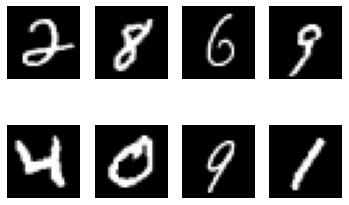

In [9]:
images = [train_dataset[i][0] for i in range(16, 24)]

for i in range(2):
    for j in range(4):
        plt.subplot(2, 4, i * 4 + j + 1)
        plt.imshow(images[i * 4 + j], cmap='gray')
        plt.axis('off')
plt.show()

---
## 模型部分

In [10]:
class MLP(Module):
    def __init__(self, input_shape, class_num, layer_num, units):
        super(MLP, self).__init__()
        
        temp = reduce(lambda x, y: x * y, input_shape, 1)
        layers = []
        for i in range(layer_num):
            if i == 0:
                layers += [Linear(temp, units[i]),
                            ReLU()]
            else:
                layers += [Linear(units[i - 1], units[i]),
                            ReLU()]
        layers += [Linear(units[-1], class_num)]
        
        self.layers = Sequential(*layers)
    
    def forward(self, x):
        y = self.layers(x)

        return y

In [11]:
def get_accuracy(y_pred, y):
    """
    type(y_pred): ndarray
    type(y): ndarray
    rtype: float
    """
    if y_pred.shape != y.shape:
        raise RuntimeError(f'y_pred.shape must be same as y.shape')
    
    total_num = len(y_pred)
    temp1 = y_pred.argmax(axis=1)
    temp2 = y.argmax(axis=1)

    acc = (temp1 == temp2).sum() / total_num

    return acc

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer, total_epoch, cur_epoch):
    pbar = tqdm(dataloader, desc=f'Epoch {cur_epoch}/{total_epoch}', unit='batch')

    for i, (x, y) in enumerate(pbar):
        x = Tensor(np.reshape(x, (len(x), -1)))
        y = Tensor(y)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        acc = get_accuracy(y_pred.data, y.data)

        if i % 5 == 0:
            pbar.set_postfix_str(f'loss={loss.data.item():.4f}, acc={acc:.4f}')

In [13]:
def test_loop(dataloader, model, loss_fn):
    steps = len(dataloader)
    loss = 0.0
    acc = 0.0
    
    with no_grad():
        for x, y in dataloader:
            x = Tensor(np.reshape(x, (len(x), -1)))
            y = Tensor(y)

            y_pred = model(x)
            loss += loss_fn(y_pred, y).data.item()

            acc += get_accuracy(y_pred.data, y.data)
    
    loss = loss / steps
    acc = acc / steps

    print(f'test_loss={loss:.4f}, test_acc={acc:.4f}')

---
## 开始训练

In [14]:
mlp = MLP(train_dataset[0][0].shape, 10, 1, [512])
print(mlp)

In [15]:
for name, param in mlp.parameters:
    print(name, param.data.shape, param.data.dtype)

layers_0_weight (512, 784) float64
layers_0_bias (512,) float64
layers_2_weight (10, 512) float64
layers_2_bias (10,) float64


In [16]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(mlp.parameters, lr=0.09)

In [17]:
epochs = 20
for i in range(epochs):
    train_loop(train_dataloader, mlp, loss_fn, optimizer, epochs, i)
    test_loop(test_dataloader, mlp, loss_fn)

Epoch 0/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.2256, test_acc=0.9347


Epoch 1/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.1612, test_acc=0.9523


Epoch 2/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.1223, test_acc=0.9635


Epoch 3/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.1040, test_acc=0.9699


Epoch 4/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0946, test_acc=0.9718


Epoch 5/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0851, test_acc=0.9750


Epoch 6/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0824, test_acc=0.9747


Epoch 7/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0759, test_acc=0.9776


Epoch 8/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0782, test_acc=0.9766


Epoch 9/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0687, test_acc=0.9792


Epoch 10/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0706, test_acc=0.9788


Epoch 11/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0679, test_acc=0.9790


Epoch 12/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0644, test_acc=0.9796


Epoch 13/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0630, test_acc=0.9801


Epoch 14/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0647, test_acc=0.9799


Epoch 15/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0663, test_acc=0.9794


Epoch 16/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0637, test_acc=0.9799


Epoch 17/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0622, test_acc=0.9808


Epoch 18/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0612, test_acc=0.9804


Epoch 19/20:   0%|          | 0/1200 [00:00<?, ?batch/s]

test_loss=0.0613, test_acc=0.9818


---
## 可视化预测结果看两眼

In [18]:
rand_indices = np.random.randint(0, len(test_dataset), (9, ))
print(rand_indices)

[7442 5601 3462 6808 7999 5246 8396  132 2624]


In [19]:
test_images = np.array([test_dataset[index][0] for index in rand_indices])
test_labels = [test_dataset[index][1] for index in rand_indices]

In [20]:
with no_grad():
    preds = mlp(Tensor(test_images.reshape(len(test_images), -1)))
print(preds.data.shape)

(9, 10)


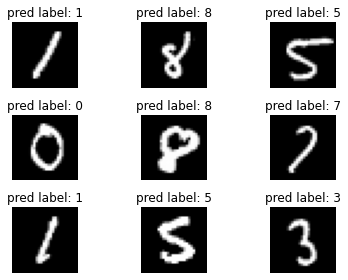

In [21]:
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i*3+j+1)
        plt.imshow(test_images[i*3+j], cmap='gray')
        plt.title(f'pred label: {preds.data[i*3+j].argmax()}')
        plt.axis('off')
plt.tight_layout()
plt.show()